In [3]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import os
import torch
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import generate_outputs
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine



In [6]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)
i1 = Image.open('/home/hice1/bgoyal7/scratch/HML/experiment_data/exp6_google_images/3/1.png').convert("RGB")
# i2 = Image.open('/home/hice1/bgoyal7/scratch/HML/experiment_data/exp1_equal_area_circles/1/1_2.png').convert("RGB")
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
# ls = [i1 for _ in range(2)]
tempinputs = processor(images=i1, return_tensors="pt").to(device).pixel_values
with torch.no_grad(): 
    cur_outputs = model(tempinputs, output_attentions = True, output_hidden_states = True)

In [4]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 46.0 MB/s eta 0:00:00:00:0100:01


In [26]:
# rollout_instance = VITAttentionGradRollout(model, discard_ratio=0.9)
# mask = rollout_instance(tempinputs, category_index=cur_outputs.logits.argmax(-1))
# print(cur_outputs.attentions[0].shape)
# print(np.max(cur_outputs.attentions[0].numpy(), axis=1).shape)
identity_stacked = np.stack([np.eye(197) for _ in range(cur_outputs.attentions[0].shape[0])])
rollout_attention = np.max(cur_outputs.attentions[0].numpy(), axis=1) + identity_stacked
print(rollout_attention.shape)
for i in range(1, len(cur_outputs.attentions)):
    # print(f'{i} attention size: {(np.max(cur_outputs.attentions[i]. numpy(), axis = 1) + np.eye(197)).shape}')
    for j in range(rollout_attention.shape[0]):
        # print(f'{i} {j} rolloutsize: {rollout_attention[j].shape}')
        # print(f'{i} {j} attentionsize: {np.max(cur_outputs.attentions[i][j].numpy(), axis = 0).shape}')
        rollout_attention[j] = rollout_attention[j] @ (np.max(cur_outputs.attentions[i][j]. numpy(), axis = 0) + np.eye(197))
print(rollout_attention.shape)

(1, 197, 197)


(1, 197, 197)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


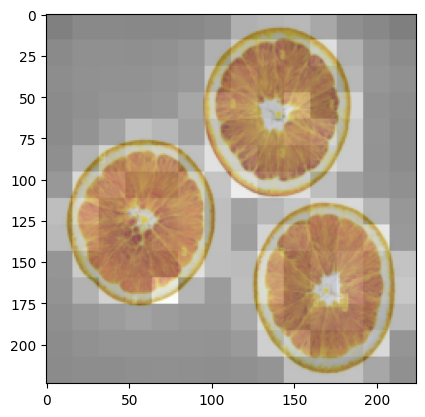

In [22]:

image_rollout = np.kron(rollout_attention[0, 1:, 0].reshape(14, 14), np.ones((16, 16)))
# print(tempinputs.shape)
plt.imshow(tempinputs.squeeze().numpy().transpose(1,2,0))
plt.imshow(image_rollout, cmap="gray", alpha=0.5)  

Identity shape: (1, 197, 197)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224)


True

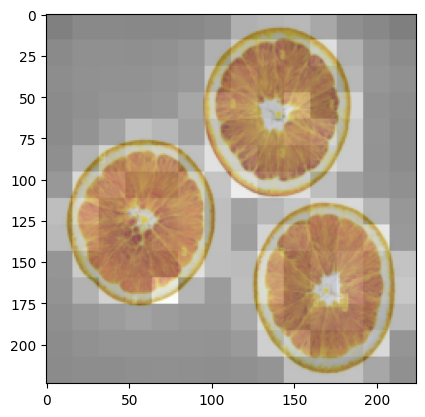

In [29]:
def get_cls_attention(outputs): 
    comp = torch.stack([torch.sum(i.cpu(), dim = 1) for i in outputs.attentions]) #Add attention across all heads 
    overall = comp.sum(dim=0) #Add attention across all layers
    identity_stacked = np.stack([np.eye(197) for _ in range(outputs.attentions[0].shape[0])])
    print(f'Identity shape: {identity_stacked.shape}')
    rollout_attention = np.max(outputs.attentions[0].cpu().numpy(), axis=1) + identity_stacked
    for i in range(1, len(outputs.attentions)):
        for j in range(rollout_attention.shape[0]):
            rollout_attention[j] = rollout_attention[j] @ (np.max(outputs.attentions[i][j].cpu().numpy(), axis = 0) + np.eye(197))

    imversion = np.kron(rollout_attention[:, 1:, 0].reshape((-1, 14, 14)), np.ones((1, 16, 16)))
    #OVERALL WILL HAVE THE ATTENTIONS FOR ALL TOKEN POSITIONS INCLUDING THE CLASSIFICATION TOKEN
    #OVERALL's SHAPE SHOULD BE : num of images x 197 x 197
    return imversion, overall


funcversion, _= get_cls_attention(cur_outputs)
print(funcversion.shape)
plt.imshow(tempinputs.squeeze().numpy().transpose(1,2,0))
plt.imshow(funcversion[0], cmap="gray", alpha=0.5)  
np.array_equal(funcversion[0], image_rollout)

In [4]:
def calculate_cosine_distance(a_array, b_array): 
        similarity_matrix = np.ones((a_array.shape[0], b_array.shape[0]))
        for i in range(a_array.shape[0]): 
            for j in range(b_array.shape[0]): 
                similarity_matrix[i, j] = cosine(a_array[i], b_array[j])
        return np.sum(similarity_matrix)/a_array.shape[0] * b_array.shape[0]
def calculate_cosine_similarity(a_array, b_array):
        similarity_matrix = cosine_similarity(a_array, b_array)
        return np.sum(similarity_matrix)/a_array.shape[0] * b_array.shape[0]
def get_similarity(embedding_dir, metric_func = calculate_cosine_similarity):
    cosinedists  = {}
    for i in os.listdir(embedding_dir): 
        a = torch.load(os.path.join(embedding_dir, i), map_location=torch.device('cpu'))
        for j in os.listdir(embedding_dir): 
            b = torch.load(os.path.join(embedding_dir, j), map_location=torch.device('cpu'))
            cosinedists[(int(i.split('.')[0]), int(j.split('.')[0]))] = metric_func(a[-1][:, 0, :], b[-1][:, 0, :])
    return cosinedists

dict1 = get_similarity('/home/hice1/bgoyal7/scratch/HML/ViT_embedding/exp1_equal_area_circles')
dict2 = get_similarity('/home/hice1/bgoyal7/scratch/HML/ViT_embedding/exp2_equal_circumference_circles')
dict3 = get_similarity('/home/hice1/bgoyal7/scratch/HML/ViT_embedding/exp3_equal_area_diff_shapes')
dict4 = get_similarity('/home/hice1/bgoyal7/scratch/HML/ViT_embedding/exp4_diff_area_diff_shapes')
dict5 = get_similarity('/home/hice1/bgoyal7/scratch/HML/ViT_embedding/exp5_diff_area_diff_shapes_in_img')
dict6 = get_similarity('/home/hice1/bgoyal7/scratch/HML/ViT_embedding/exp6_google_images')

/tmp/ipykernel_39445/3975262178.py:29: RuntimeWarning: overflow encountered in exp
  params, covariance = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, x, y, maxfev=1000000)


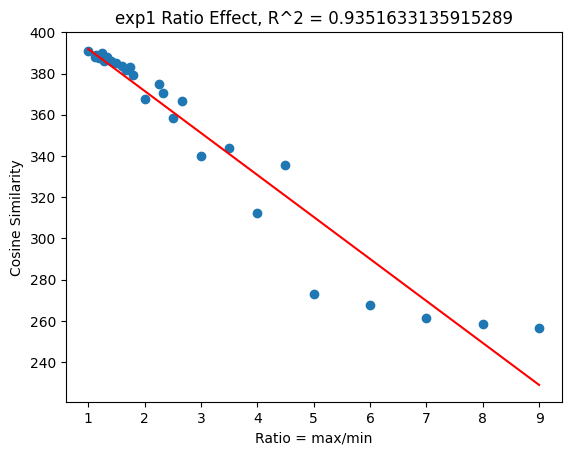

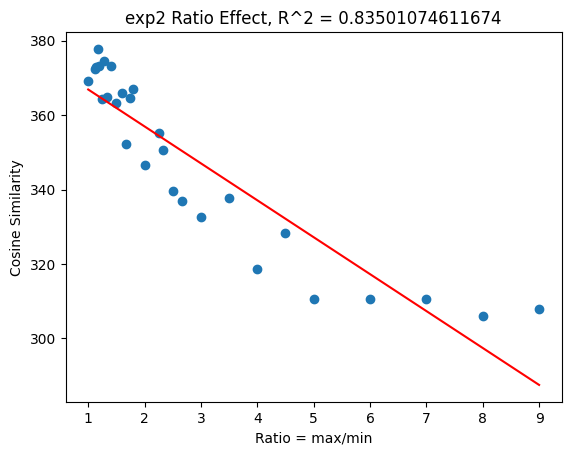

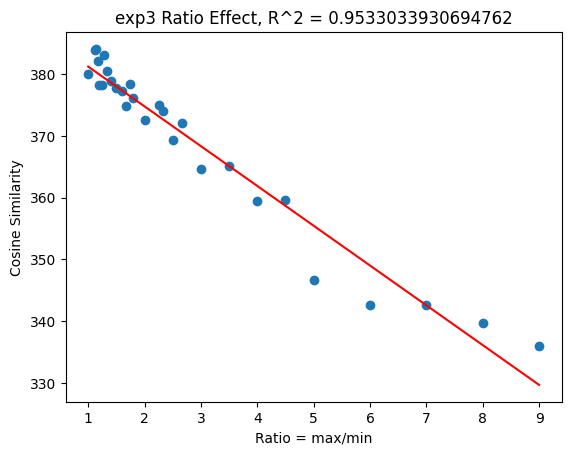

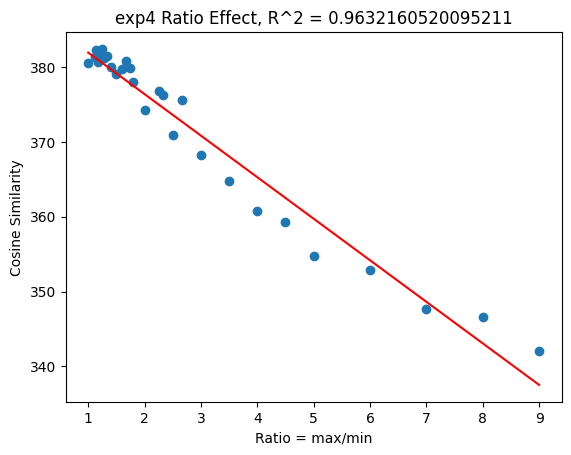

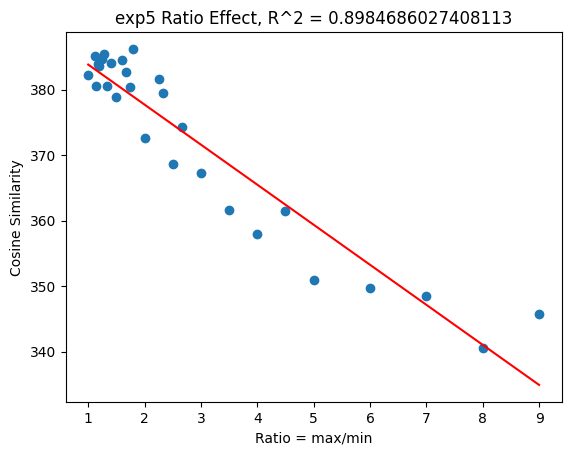

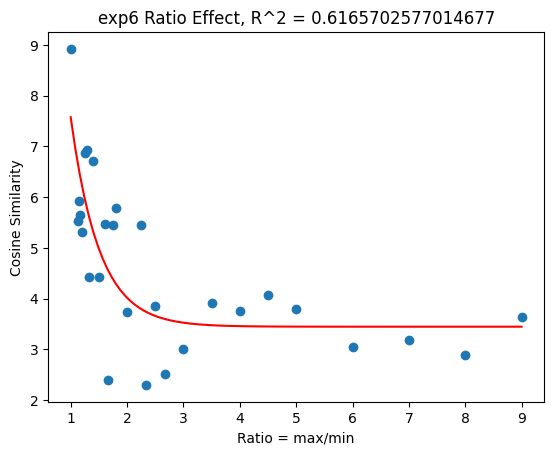

In [6]:
from scipy.optimize import curve_fit
# a = {1:3}
# print(a)
def handle_mds(dict, expname): 
    ls = np.ones((9, 9))
    for i in dict: 
        ls[i[0]-1][i[1]-1] = dict[i]
    func = MDS(n_components =1, dissimilarity = 'precomputed')
    ls = ls/np.max(ls)
    func.fit(ls)
    fig, ax = plt.subplots()
    ax.set_title(expname + ' stress:' + str(func.stress_))
    for i in range(1, 10):
        ax.annotate(i, (func.embedding_[i-1], (0.005)))
    ax.scatter(x=func.embedding_, y=[0 for _ in range(func.embedding_.shape[0])])
def get_ratio_plot(dict, expname): 
    x, y = [], []
    td = {}
    for (i, val) in dict.items(): 
        ind  = max(i[0],i[1])/min(i[0],i[1])
        if ind not in td: 
            td[ind] = []
        td[ind].append(val)
    for (i, val) in td.items():
        x.append(i)
        y.append(np.mean(val))
    fig, ax = plt.subplots()
    # Fit the curve
    params, covariance = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, x, y, maxfev=1000000)

    # Extract the fitted parameters
    a_fit, b_fit, c_fit = params
    # Calculate the predicted values from the fitted curve
    y_pred = a_fit * np.exp(np.array(x)* - b_fit) + c_fit

    # Calculate the mean of the actual data points
    y_mean = np.mean(y)
    
    # Calculate R^2
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - y_mean)**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # print("R-squared value =", r_squared)
    
    # Plot the data points
    # plt.scatter(x, y, label='Data Points', color='blue')
    
    # Plot the fitted curve
    x_fit = np.linspace(min(x), max(x), 100)  # Generate points for the fitted curve
    y_fit = a_fit * np.exp(np.array(x_fit)* - b_fit) + c_fit
    ax.plot(x_fit, y_fit, label='Fitted Curve', color='red')

    ax.scatter(x, y)
    ax.set_title(expname + ' Ratio Effect, R^2 = ' + str(r_squared))
    ax.set_ylabel('Cosine Similarity')
    ax.set_xlabel('Ratio = max/min')
    plt.savefig(expname + '_ratio.png')
    # if save_dir is not None:
    #     plt.savefig(save_dir + '/' + expname + xlabel + '.png')
get_ratio_plot(dict1, 'exp1')
get_ratio_plot(dict2, 'exp2')
get_ratio_plot(dict3, 'exp3')
get_ratio_plot(dict4, 'exp4')
get_ratio_plot(dict5, 'exp5')
get_ratio_plot(dict6, 'exp6')
# handle_dict(dict2, 'exp2')
# handle_dict(dict3, 'exp3')
# handle_dict(dict4, 'exp4')
# handle_dict(dict5, 'exp5')
# handle_dict(dict6, 'exp6')

In [20]:

def get_similarity(embedding_dir):
    def calculate_cosine_similarity(a_array, b_array):
        similarity_matrix = cosine_similarity(a_array, b_array)
        return np.sum(similarity_matrix)/a_array.shape[0] * b_array.shape[0]
    cosinedists  = {}
    for i in os.listdir(embedding_dir): 
        a = torch.load(os.path.join(embedding_dir, i), map_location=torch.device('cpu'))
        firstdim = a[-1].shape[0]
        for j in os.listdir(embedding_dir): 
            b = torch.load(os.path.join(embedding_dir, j), map_location=torch.device('cpu'))
            cosinedists[(int(i.split('.')[0]), int(j.split('.')[0]))] = calculate_cosine_similarity(a[-1].reshape(firstdim, -1), b[-1].reshape(firstdim, -1))
        #[:, 0, :] instead of the reshaped version
    return cosinedists
alldimsd1 = get_similarity('/home/hice1/bgoyal7/scratch/HML/ViT_embedding/exp1_equal_area_circles')

/home/hice1/bgoyal7/.conda/envs/vitinf/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


TypeError: get_plots() got an unexpected keyword argument 'cosinedists'

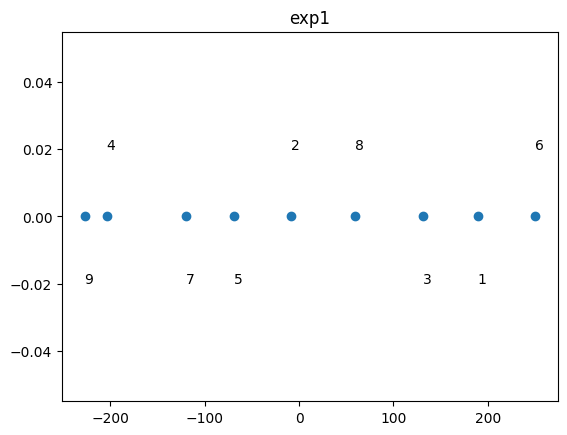

In [23]:
handle_dict(alldimsd1, 'exp1')

generate_outputs.get_plots(None, 'exp1', cosinedists = alldimsd1)